<a href="https://colab.research.google.com/github/azdfkpot/NNs-and-DEs/blob/main/trans_equ.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **PINNs for the transport equation**

$$
\begin{cases}
\frac{∂u}{∂t} - \frac{∂u}{∂x} = 0, \quad (x,t)\in [-2,2]\times[0,2]\\
u (x,t=0) = 1/ (1+x^2).
\end{cases}
$$
  The exact solution:
  $$
  u(x,t)=\frac{1}{1+(x-t)^2}.
  $$

In [ ]:
import tensorflow as tf

class Network:


    @classmethod
    def build(cls, num_inputs=2, layers=[32,32,32,32,32,32], activation='tanh', num_outputs=1):


        # input layer
        inputs = tf.keras.layers.Input(shape=(num_inputs,))
        # hidden layers
        x = inputs
        for layer in layers:
            x = tf.keras.layers.Dense(layer, activation=activation,
                kernel_initializer='he_normal')(x)
        # output layer
        outputs = tf.keras.layers.Dense(num_outputs,
            kernel_initializer='he_normal')(x)

        return tf.keras.models.Model(inputs=inputs, outputs=outputs)

In [ ]:
import tensorflow as tf

class GradientLayer(tf.keras.layers.Layer):


    def __init__(self, model, **kwargs):


        self.model = model
        super().__init__(**kwargs)

    def call(self, tx):


        with tf.GradientTape() as g:
            g.watch(tx)
            with tf.GradientTape() as gg:
                gg.watch(tx)
                u = self.model(tx)
            du_dtx = gg.batch_jacobian(u, tx)
            du_dt = du_dtx[..., 0]
            du_dx = du_dtx[..., 1]
        d2u_dtx2 = g.batch_jacobian(du_dtx, tx)
        d2u_dt2 = d2u_dtx2[..., 0, 0]
        d2u_dx2 = d2u_dtx2[..., 1, 1]

        return u, du_dt, du_dx, d2u_dt2, d2u_dx2

In [ ]:
import scipy.optimize
import numpy as np
import tensorflow as tf

class L_BFGS_B:


    def __init__(self, model, x_train, y_train, factr=1e5, m=50, maxls=50, maxiter=30000):


        # set attributes
        self.model = model
        self.x_train = [ tf.constant(x, dtype=tf.float32) for x in x_train ]
        self.y_train = [ tf.constant(y, dtype=tf.float32) for y in y_train ]
        self.factr = factr
        self.m = m
        self.maxls = maxls
        self.maxiter = maxiter
        self.metrics = ['loss']
        # initialize the progress bar
        self.progbar = tf.keras.callbacks.ProgbarLogger(
            count_mode='steps', stateful_metrics=self.metrics)
        self.progbar.set_params( {
            'verbose':1, 'epochs':1, 'steps':self.maxiter, 'metrics':self.metrics})

    def set_weights(self, flat_weights):


        # get model weights
        shapes = [ w.shape for w in self.model.get_weights() ]
        # compute splitting indices
        split_ids = np.cumsum([ np.prod(shape) for shape in [0] + shapes ])
        # reshape weights
        weights = [ flat_weights[from_id:to_id].reshape(shape)
            for from_id, to_id, shape in zip(split_ids[:-1], split_ids[1:], shapes) ]
        # set weights to the model
        self.model.set_weights(weights)

    @tf.function
    def tf_evaluate(self, x, y):


        with tf.GradientTape() as g:
            loss = tf.reduce_mean(tf.keras.losses.mse(self.model(x), y))
        grads = g.gradient(loss, self.model.trainable_variables)
        return loss, grads

    def evaluate(self, weights):


        # update weights
        self.set_weights(weights)
        # compute loss and gradients for weights
        loss, grads = self.tf_evaluate(self.x_train, self.y_train)
        # convert tf.Tensor to flatten ndarray
        loss = loss.numpy().astype('float64')
        grads = np.concatenate([ g.numpy().flatten() for g in grads ]).astype('float64')

        return loss, grads

    def callback(self, weights):

        self.progbar.on_batch_begin(0)
        loss, _ = self.evaluate(weights)
        self.progbar.on_batch_end(0, logs=dict(zip(self.metrics, [loss])))

    def fit(self):


        # get initial weights as a flat vector
        initial_weights = np.concatenate(
            [ w.flatten() for w in self.model.get_weights() ])
        # optimize the weight vector
        print('Optimizer: L-BFGS-B (maxiter={})'.format(self.maxiter))
        self.progbar.on_train_begin()
        self.progbar.on_epoch_begin(1)
        scipy.optimize.fmin_l_bfgs_b(func=self.evaluate, x0=initial_weights,
            factr=self.factr, m=self.m, maxls=self.maxls, maxiter=self.maxiter,
            callback=self.callback)
        self.progbar.on_epoch_end(1)
        self.progbar.on_train_end()


In [ ]:
import tensorflow as tf

class PINN:


    def __init__(self, network, c=1):


        self.network = network
        self.c = c
        self.grads = GradientLayer(self.network)

    def build(self):


        # equation input: (t, x)
        tx_eqn = tf.keras.layers.Input(shape=(2,))
        # initial condition input: (t=0, x)
        tx_ini = tf.keras.layers.Input(shape=(2,))
        # boundary condition input: (t, x=-1) or (t, x=+1)

        # compute gradients
        u, du_dt, du_dx, d2u_dt2, d2u_dx2 = self.grads(tx_eqn)
        # equation output being zero
        u_eqn = du_dt + self.c * du_dx

        # initial condition output
        u_ini, du_dt_ini, _, _, _ = self.grads(tx_ini)


        # build the PINN model for the wave equation
        return tf.keras.models.Model(
            inputs=[tx_eqn, tx_ini],
            outputs=[u_eqn, u_ini])


Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 2)]               0         
                                                                 
 dense_28 (Dense)            (None, 32)                96        
                                                                 
 dense_29 (Dense)            (None, 32)                1056      
                                                                 
 dense_30 (Dense)            (None, 32)                1056      
                                                                 
 dense_31 (Dense)            (None, 32)                1056      
                                                                 
 dense_32 (Dense)            (None, 32)                1056      
                                                                 
 dense_33 (Dense)            (None, 32)                1056

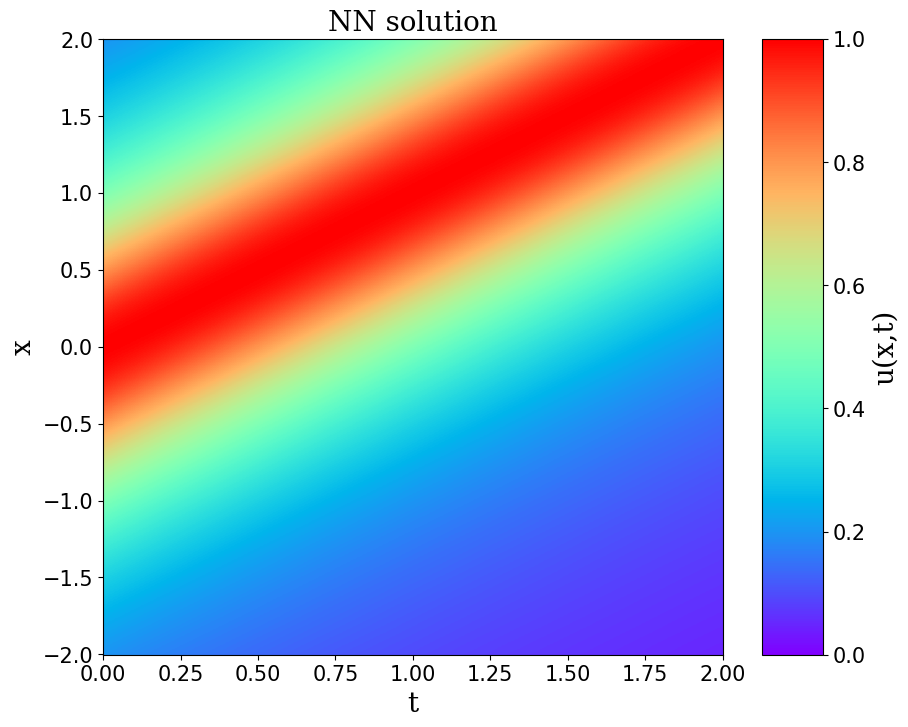

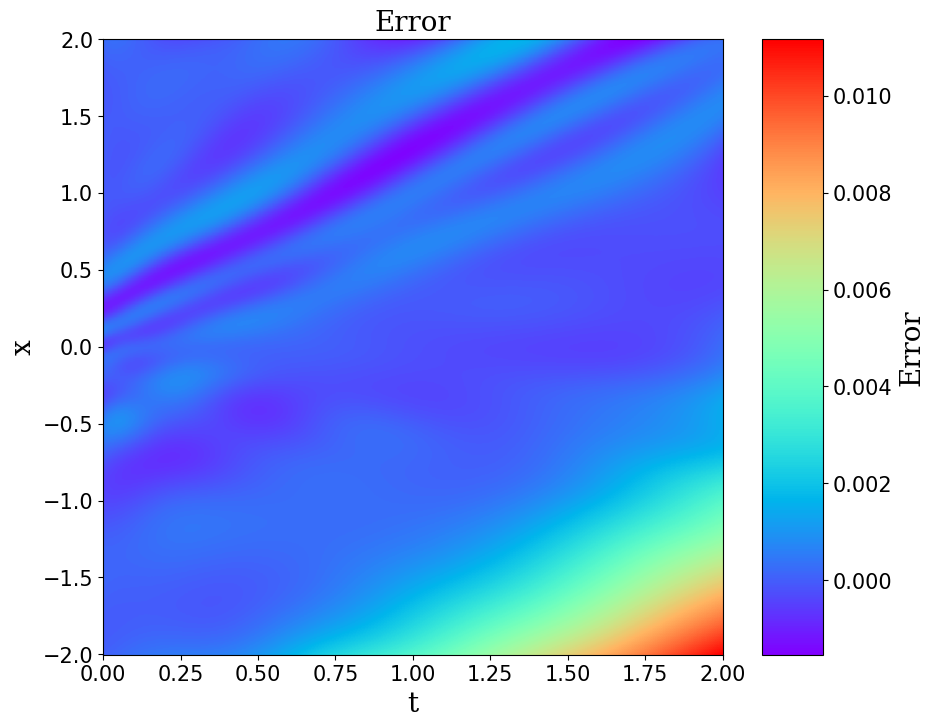

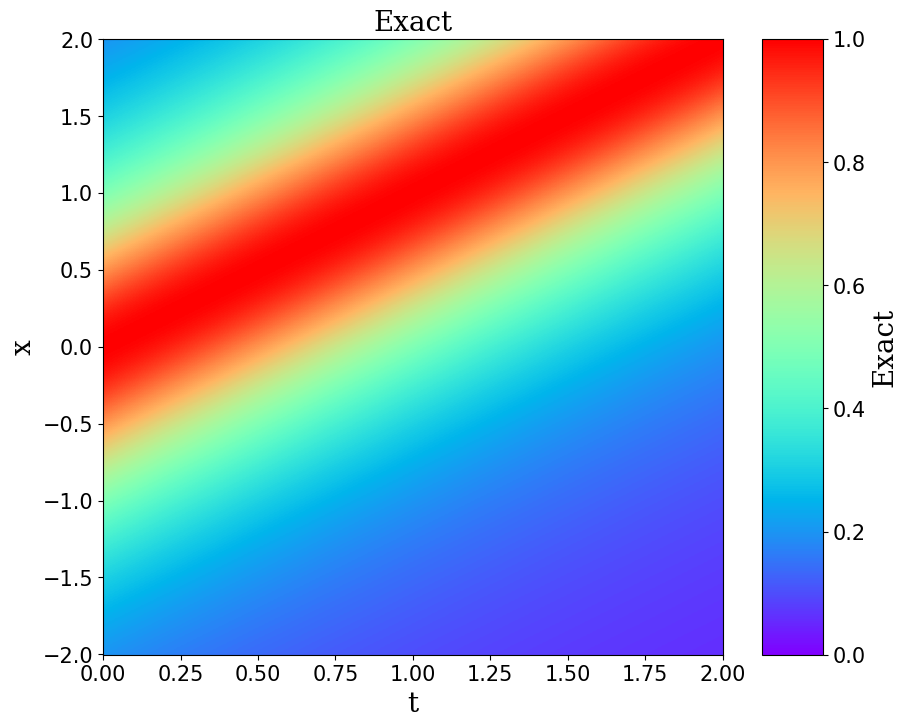

1/1 [==============================] - 0s 22ms/step


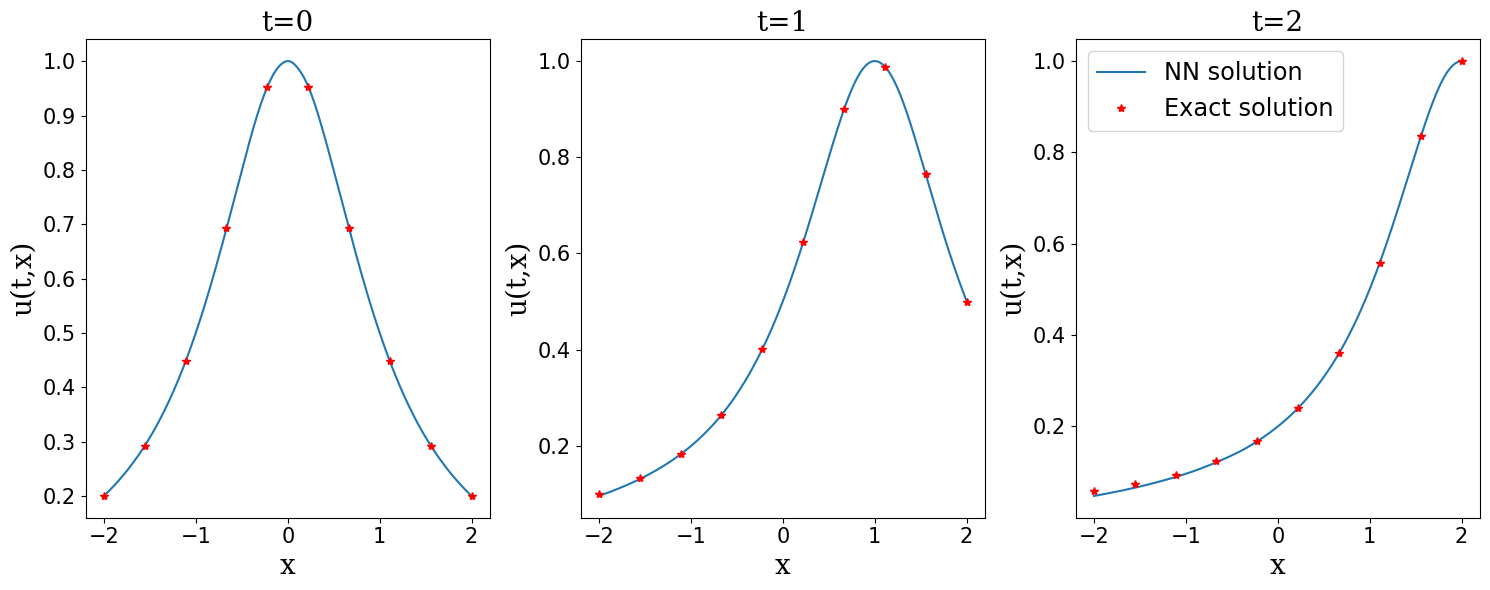

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.gridspec import GridSpec
from numpy import linalg as LA
from matplotlib import cm
from matplotlib.ticker import LinearLocator

# Initial condition function
def u0(tx):


    t = tx[..., 0, None]
    x = tx[..., 1, None]

    return   1/(1+x**2)

# Halton distribution
def primes_from_2_to(n):

    sieve = np.ones(n // 3 + (n % 6 == 2), dtype=np.bool)
    for i in range(1, int(n ** 0.5) // 3 + 1):
        if sieve[i]:
            k = 3 * i + 1 | 1
            sieve[k * k // 3::2 * k] = False
            sieve[k * (k - 2 * (i & 1) + 4) // 3::2 * k] = False
    return np.r_[2, 3, ((3 * np.nonzero(sieve)[0][1:] + 1) | 1)]


def van_der_corput(n_sample, base=2):

    sequence = []
    for i in range(n_sample):
        n_th_number, denom = 0., 1.
        while i > 0:
            i, remainder = divmod(i, base)
            denom *= base
            n_th_number += remainder / denom
        sequence.append(n_th_number)

    return sequence


def halton(dim, n_sample):

    big_number = 10
    while 'Not enought primes':
        base = primes_from_2_to(big_number)[:dim]
        if len(base) == dim:
            break
        big_number += 1000

    # Generate a sample using a Van der Corput sequence per dimension.
    sample = [van_der_corput(n_sample + 1, dim) for dim in base]
    sample = np.stack(sample, axis=-1)[1:]

    return sample


if __name__ == '__main__':


    # number of training samples
    num_train_samples = 10000
    # number of test samples
    num_test_samples = 1000

    # build a core network model
    network = Network.build()
    network.summary()
    # build a PINN model
    pinn = PINN(network).build()

    # Time and space domain
    t=2
    x_f=2
    x_ini=-2

    ''' Example of parametric distribution over the domain:

    num = np.sqrt(num_train_samples)
    num = int(np.round(num,0))

    epsilon=1e-3
    x=np.linspace(-2+epsilon,2-epsilon,num)
    t=np.linspace(0+epsilon,2-epsilon,num)

    T, X = np.meshgrid(t,x)

    tx_eqn=np.random.rand(num**2, 2)
    tx_eqn[...,0]=T.reshape((num**2,))
    tx_eqn[...,1]=X.reshape((num**2,))
    '''

    ''' Example of parametric distribution over the domain:

    tx_eqn = halton(2, num_train_samples)
    tx_eqn[..., 0] = t*tx_eqn[..., 0]
    tx_eqn[..., 1] = (x_f-x_ini)*tx_eqn[..., 1] + x_ini
    '''

    # create training input
    tx_eqn = np.random.rand(num_train_samples, 2)
    tx_eqn[..., 0] = t*tx_eqn[..., 0]                # t =  0 ~ +2
    tx_eqn[..., 1] = (x_f-x_ini)*tx_eqn[..., 1] + x_ini            # x = -2 ~ +2
    tx_ini = np.random.rand(num_train_samples, 2)
    tx_ini[..., 0] = 0                               # t = 0
    tx_ini[..., 1] = (x_f-x_ini)*tx_ini[..., 1] + x_ini            # x = -1 ~ +1
    # create training output
    u_zero = np.zeros((num_train_samples, 1))
    u_ini = u0(tf.constant(tx_ini)).numpy()


    # train the model using L-BFGS-B algorithm
    x_train = [tx_eqn, tx_ini]
    y_train = [u_zero, u_ini]
    lbfgs = L_BFGS_B(model=pinn, x_train=x_train, y_train=y_train)
    lbfgs.fit()

    # prediction of u(t,x) distribution
    t_flat = np.linspace(0, t, num_test_samples)
    x_flat = np.linspace(x_ini, x_f, num_test_samples)
    t, x = np.meshgrid(t_flat, x_flat)
    tx = np.stack([t.flatten(), x.flatten()], axis=-1)
    u = network.predict(tx, batch_size=num_test_samples)
    u = u.reshape(t.shape)


    # plot u(t,x) distribution as a color-map

    fig= plt.figure(figsize=(10,8))
    vmin, vmax = 0, 1
    plt.pcolormesh(t, x, u, cmap='rainbow', norm=Normalize(vmin=vmin, vmax=vmax))
    font1 = {'family':'serif','size':20}
    font2 = {'family':'serif','size':15}

    plt.title("NN solution", fontdict = font1)
    plt.xlabel("t", fontdict = font1)
    plt.ylabel("x", fontdict = font1)
    plt.tick_params(axis='both', which='major', labelsize=15)

    cbar = plt.colorbar(pad=0.05, aspect=10)
    cbar.set_label('u(x,t)', fontdict = font1)
    cbar.mappable.set_clim(vmin, vmax)
    cbar.ax.tick_params(labelsize=15)
    plt.show()

    # Exact solution U and Error E
    U = 1/(1+(x-t)**2)
    E = (U-u)

    fig= plt.figure(figsize=(10,8))
    vmin, vmax = np.min(np.min(E)), np.max(np.max(E))
    plt.pcolormesh(t, x, E, cmap='rainbow', norm=Normalize(vmin=vmin, vmax=vmax))
    font1 = {'family':'serif','size':20}
    font2 = {'family':'serif','size':15}

    plt.title("Error", fontdict = font1)
    plt.xlabel("t", fontdict = font1)
    plt.ylabel("x", fontdict = font1)
    plt.tick_params(axis='both', which='major', labelsize=15)

    cbar = plt.colorbar(pad=0.05, aspect=10)
    cbar.set_label('Error', fontdict = font1)
    cbar.mappable.set_clim(vmin, vmax)
    cbar.ax.tick_params(labelsize=15)
    plt.show()



    fig= plt.figure(figsize=(10,8))
    vmin, vmax = 0, 1
    plt.pcolormesh(t, x, U, cmap='rainbow', norm=Normalize(vmin=vmin, vmax=vmax))
    font1 = {'family':'serif','size':20}
    font2 = {'family':'serif','size':15}

    plt.title("Exact", fontdict = font1)
    plt.xlabel("t", fontdict = font1)
    plt.ylabel("x", fontdict = font1)
    plt.tick_params(axis='both', which='major', labelsize=15)

    cbar = plt.colorbar(pad=0.05, aspect=10)
    cbar.set_label('Exact', fontdict = font1)
    cbar.mappable.set_clim(vmin, vmax)
    cbar.ax.tick_params(labelsize=15)
    plt.show()

    # Comparison at time 0, 1 and 2

    fig,(ax1, ax2, ax3)  = plt.subplots(1,3,figsize=(15,6))
    x_flat_ = np.linspace(x_ini, x_f, 10)


    U_1 = 1/(1+(x_flat_)**2)
    tx = np.stack([np.full(t_flat.shape, 0), x_flat], axis=-1)
    u_ = network.predict(tx, batch_size=num_test_samples)
    ax1.plot(x_flat, u_)
    ax1.plot(x_flat_, U_1,'r*')
    font1 = {'family':'serif','size':20}
    font2 = {'family':'serif','size':15}
    ax1.set_title('t={}'.format(0), fontdict = font1)
    ax1.set_xlabel('x', fontdict = font1)
    ax1.set_ylabel('u(t,x)', fontdict = font1)
    ax1.tick_params(labelsize=15)


    U_1 = 1/(1+(x_flat_-1)**2)
    tx = np.stack([np.full(t_flat.shape, 1), x_flat], axis=-1)
    u_ = network.predict(tx, batch_size=num_test_samples)
    ax2.plot(x_flat, u_)
    ax2.plot(x_flat_, U_1,'r*')
    ax2.set_title('t={}'.format(1), fontdict = font1)
    ax2.set_xlabel('x', fontdict = font1)
    ax2.set_ylabel('u(t,x)', fontdict = font1)
    ax2.tick_params(labelsize=15)


    U_1 = 1/(1+(x_flat_-2)**2)
    tx = np.stack([np.full(t_flat.shape, 2), x_flat], axis=-1)
    u_ = network.predict(tx, batch_size=num_test_samples)
    ax3.plot(x_flat, u_,label='NN solution')
    ax3.plot(x_flat_, U_1,'r*', label='Exact solution')
    ax3.set_title('t={}'.format(2), fontdict = font1)
    ax3.set_xlabel('x', fontdict = font1)
    ax3.set_ylabel('u(t,x)', fontdict = font1)
    ax3.legend(loc='best', fontsize = 'xx-large')
    ax3.tick_params(labelsize=15)

    plt.tight_layout()
    plt.show()
